Useful links

- https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/
- https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
- https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-rnn-cb6ebc594677
- https://towardsdatascience.com/time-series-forecasting-with-rnns-ff22683bbbb0
- https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816
- https://towardsdatascience.com/analyzing-time-series-data-in-pandas-be3887fdd621
- http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/
- https://colah.github.io/posts/2015-09-NN-Types-FP/
- https://pytorch.org/docs/stable/nn.html#rnn

In [1]:
import pandas as pd
import numpy as np
import requests as rq
import datetime as dt
import traceback as tb
import torch

tnn = torch.nn
top = torch.optim
from torch.utils import data as tdt

### Download India's data

In [2]:
# get daily time series data from covid19india
resp = rq.get("https://api.covid19india.org/data.json")
ts = resp.json()['cases_time_series']

r = {
    "date": [],
    "confirmed": [],
    "deceased": [],
    "recovered": []
}

for d in ts:
    try:
        r['date'].append(dt.datetime.strptime(d['date'] + "2020", '%d %B %Y'))
        r['confirmed'].append(np.int64(d['dailyconfirmed']))
        r['deceased'].append(np.int64(d['dailydeceased']))
        r['recovered'].append(np.int64(d['dailyrecovered']))
    except Exception as e:
        print(d['date'])
        tb.print_exc()

df = pd.DataFrame(r)
df.sort_values('date', inplace=True)
df.sample()

,date,confirmed,deceased,recovered
44,2020-03-14,11,1,0


### Italy's and Spain's data

In [3]:
it_df = pd.read_csv('csv/italy.csv')
print(it_df.sample())

es_df = pd.read_csv('csv/spain.csv')
print(es_df.sample())

          date  deceased  recovered  confirmed  active  daily
77  2020-05-08     30201    99023.0     217185   87961   1327
          date  deaths  recovered  confirmed  active  daily
27  2020-03-22  2136.0       3140      41182   35906   4625


### Prep data

In [6]:
def get_rnn_dataset(series, seq_len):
    """get rnn training dataset, given a series and seq_len"""
    ip_seq = np.array(series[:-1], dtype=np.float32)
    op_seq = np.array(series[1:], dtype=np.float32)
    data_len = len(series) - 1

    ips = []
    ops = []
    for i in range(data_len - seq_len + 1):
        ip, op = ip_seq[i : i+seq_len], op_seq[i : i+seq_len]
        ips.append(ip)
        ops.append(op)
    ips = np.array(ips, dtype=np.float32)
    ops = np.array(ops, dtype=np.float32)

    # convert from numpy to torch
    ip_t = torch.from_numpy(ips)
    op_t = torch.from_numpy(ops)

    dataset = tdt.TensorDataset(ip_t, op_t)
    return dataset

# preprocess data: sma(6) and normalise by 10k
in_cnf = np.array(df['confirmed'][37:].rolling(6, center=True, min_periods=1).mean()) / 10000
it_cnf = np.array(it_df['daily'].rolling(6, center=True, min_periods=1).mean()) / 10000
es_cnf = np.array(es_df['daily'].rolling(6, center=True, min_periods=1).mean()) / 10000

# Choose among India or Italy or Spain here
cnf = in_cnf # np.append(it_cnf, es_cnf)
SEQ_LEN = 5
dataset = get_rnn_dataset(cnf, SEQ_LEN)

val_len = int(0.2 * len(dataset))
train_len = len(dataset) - val_len
train_set, val_set = tdt.random_split(dataset, (train_len, val_len))

seq_train_loader = tdt.DataLoader(train_set, shuffle=False, batch_size=1)
rnd_train_loader = tdt.DataLoader(train_set, shuffle=True, batch_size=1)
val_loader = tdt.DataLoader(val_set, shuffle=True, batch_size=1)

### Define NN and train

epoch:   0 val_loss:  0.00990
epoch:   1 val_loss:  0.00303
epoch:   2 val_loss:  0.00034
epoch:   3 val_loss:  0.00019
epoch:   4 val_loss:  0.00022
epoch:   5 val_loss:  0.00015
epoch:   6 val_loss:  0.00015
epoch:   7 val_loss:  0.00014
epoch:   8 val_loss:  0.00013
epoch:   9 val_loss:  0.00062
epoch:  10 val_loss:  0.00012
epoch:  11 val_loss:  0.00022
epoch:  12 val_loss:  0.00017
epoch:  13 val_loss:  0.00029
epoch:  14 val_loss:  0.00011
epoch:  15 val_loss:  0.00074
epoch:  16 val_loss:  0.00021
epoch:  17 val_loss:  0.00012
epoch:  18 val_loss:  0.00018
epoch:  19 val_loss:  0.00009


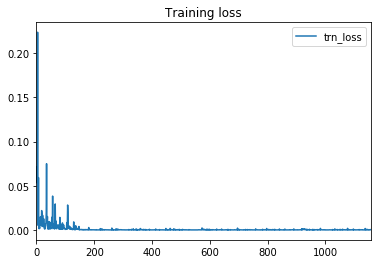

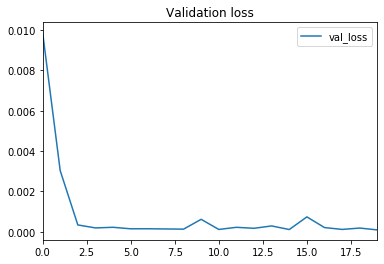

In [12]:
class Forecaster(tnn.Module):
    def __init__(self, seq_len=1, hidden_size=1, num_layers=1):
        super(Forecaster, self).__init__()
        
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = tnn.RNN(input_size=1, hidden_size=self.hidden_size, num_layers=self.num_layers)
#         self.gru = tnn.GRU(input_size=1, hidden_size=self.hidden_size, num_layers=self.num_layers)
#         self.lstm = tnn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=self.num_layers)
        self.linear = tnn.Linear(self.hidden_size, 1)
#         self.sigmoid = tnn.Sigmoid()
    
    def forward(self, ip, h=None):
        rnn_out, rnn_h = self.rnn(ip, h)
#         return (torch.squeeze(rnn_out), torch.squeeze(rnn_h))
        # linear layer
        final_out = []
        for i in range(self.seq_len):
            linear_out = self.linear(rnn_out[i].view(self.hidden_size))
            final_out.append(linear_out)
        return torch.stack(final_out).view(self.seq_len), rnn_h
    
    def predict(self, ip, num_predictions=1):
        preds = []
        with torch.no_grad():
            pred = ip
            h = None
            while(num_predictions):
                pred, h = self.forward(pred.view(self.seq_len, 1, 1), h)
                preds.append(pred.view(self.seq_len)[-1])
                num_predictions -= 1
        return torch.stack(preds)

HIDDEN_SIZE = 2
NUM_LAYERS = 1
LEARNING_RATE = 0.01

model = Forecaster(seq_len=SEQ_LEN, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
loss_fn = tnn.MSELoss()
optimizer = top.Adam(model.parameters(), lr=LEARNING_RATE)

# TRAIN
trn_loss_vals = []
val_loss_vals = []

NUM_EPOCHS = 20
for e in range(NUM_EPOCHS):
    # train
    for i, data in enumerate(rnd_train_loader):
        ip, op = data        
        optimizer.zero_grad() # set grads to 0
        pred, _ = model(ip.view(SEQ_LEN, 1, 1)) # predict
        loss = loss_fn(pred, op.view(SEQ_LEN)) # calc loss
        loss.backward() # calc and assign grads
        optimizer.step() # update weights

        # logging
        trn_loss_vals.append(loss.item())
        if i == 0:
#             print("epoch:", f"{e:3}", "iter:", f"{i:3}", "trn_loss:", f"{loss.item(): .5f}")
            pass
    
    # val after each epoch
    with torch.no_grad():
        val_losses = []
        for i, data in enumerate(val_loader):
            ip, op = data
            pred, _ = model(ip.view(SEQ_LEN, 1, 1))
            loss = loss_fn(pred, op.view(SEQ_LEN))
            val_losses.append(loss)
        avg_val_loss = torch.stack(val_losses).mean().item()
        val_loss_vals.append(avg_val_loss)
        print("epoch:", f"{e:3}", "val_loss:", f"{avg_val_loss: .5f}")

df_trn_loss = pd.DataFrame({
    'trn_loss': trn_loss_vals
})
_ = df_trn_loss.plot(
    y='trn_loss',
    title='Training loss'
)

df_val_loss = pd.DataFrame({
    'val_loss': val_loss_vals
})
_ = df_val_loss.plot(
    y='val_loss',
    title='Validation loss'
)

### Test
- future values on any country's data

IN: tensor([5025.5000, 5394.6670, 5690.6665, 5819.0000, 6116.7500])
OUT: tensor([6071.9438, 6036.5312, 6008.4233, 5986.0371, 5968.1602, 5953.8535,
        5942.3857, 5933.1797, 5925.7837, 5919.8345, 5915.0474, 5911.1929,
        5908.0889, 5905.5869, 5903.5698, 5901.9448, 5900.6348, 5899.5776,
        5898.7261, 5898.0386, 5897.4844, 5897.0376, 5896.6768, 5896.3857,
        5896.1519, 5895.9619, 5895.8096, 5895.6865, 5895.5874, 5895.5068,
        5895.4424, 5895.3911, 5895.3496, 5895.3154, 5895.2881, 5895.2661,
        5895.2480, 5895.2344, 5895.2231, 5895.2139, 5895.2065, 5895.2002,
        5895.1958, 5895.1909, 5895.1875, 5895.1851, 5895.1826, 5895.1807,
        5895.1787, 5895.1782])


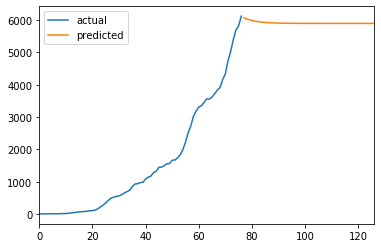

In [13]:
# CHOOSE FROM IN, IT OR ES HERE
df_cnf = in_cnf
# df_cnf = np.array([8000, 7600, 7300, 6900, 6650], dtype=np.float32) / 10000

test_in = df_cnf[-SEQ_LEN:]
t = torch.tensor(
    test_in.reshape(SEQ_LEN, 1, 1),
    dtype=torch.float32
)
print("IN:", t.view(SEQ_LEN) * 10000)
out = model.predict(t, num_predictions=50)
print("OUT:", out * 10000)

orig_df = pd.DataFrame({
    'actual': df_cnf * 10000
})
fut_df = pd.DataFrame({
    'predicted': (out.numpy() * 10000)
})
orig_df = orig_df.append(fut_df, ignore_index=True, sort=False)
_ = orig_df.plot()

- on training data

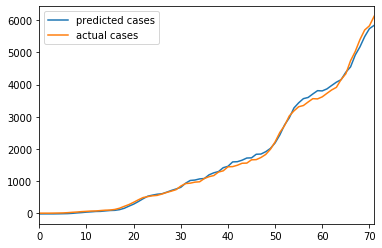

In [14]:
pred_vals = []
out_vals = []
for data in seq_data_loader:
    ip, op = data
    pred = model.predict(ip.view(SEQ_LEN, 1, 1))
    pred_vals.append(pred.item() * 10000)
    out_vals.append(op.view(SEQ_LEN)[-1].item() * 10000)

cmp_df = pd.DataFrame({
    'predicted cases': pred_vals,
    'actual cases': out_vals
})
_ = cmp_df.plot()

In [31]:
for k in model.state_dict().keys():
    print(k, "=", model.state_dict()[k])

rnn.weight_ih_l0 = tensor([[-1.4046],
        [-1.1551]])
rnn.weight_hh_l0 = tensor([[-0.2088,  0.2843],
        [ 0.2955, -0.4304]])
rnn.bias_ih_l0 = tensor([0.1908, 0.6346])
rnn.bias_hh_l0 = tensor([ 0.0838, -0.2946])
linear.weight = tensor([[-0.5144, -0.3218]])
linear.bias = tensor([0.2418])
